In [1]:
import gymnasium
import cookiedisaster
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
import seaborn as sns
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque

In [2]:
env = gymnasium.make('cookiedisaster/GridWorld-v0', render_mode="rgb_array")

2. Use a linear approximation to approximate $q_\pi(a,s)$ and solve the control problem using Q-learning. 
You may want to consider the use of feature engineering to pre-process the state.

In [3]:
def get_features(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    cookie_time = obs["cookie"]["time"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, cookie_time, dist]

In [5]:
observation_examples = []

obs, _ = env.reset()
for _ in range(10000):
    action = env.action_space.sample()  # random policy
    next_obs, _, _, _, info = env.step(action)
    observation_examples.append(get_features(next_obs, info))

observation_examples = np.array(observation_examples)

In [6]:
scaler = StandardScaler()
featurizer = FeatureUnion([
    ("rbf1", RBFSampler(gamma=4.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])

featurizer.fit_transform(scaler.fit_transform(observation_examples))

array([[ 0.105856  , -0.00139431, -0.02175495, ...,  0.1041398 ,
         0.05925938,  0.12054977],
       [ 0.08755171, -0.10087211, -0.05576295, ...,  0.11206562,
         0.07000526,  0.1227766 ],
       [ 0.06661021, -0.14142063, -0.08569698, ...,  0.1190815 ,
         0.08021   ,  0.12488758],
       ...,
       [-0.00579673,  0.14114118,  0.13908513, ..., -0.08684983,
        -0.04225099,  0.13482053],
       [ 0.0368275 , -0.02517993,  0.13060899, ..., -0.13943859,
        -0.02908735,  0.13932221],
       [-0.07653549, -0.13989139,  0.00973747, ..., -0.12414908,
        -0.01175493,  0.11220815]])

In [7]:
class FunctionApproximator:
    def __init__(self):
        self.models = []
        # for each action there is separate SGDRegressor, which allows to 
        # estimate the Q-value for each action-state pair
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            obs, info = env.reset()
            # models are fitted with a default target value to set up the model
            model.partial_fit([self.featurize_state(get_features(obs, info))], [0])
            self.models.append(model)

    def featurize_state(self, state):
        scaled = scaler.transform([state])
        features = featurizer.transform(scaled)
        return features[0]

    def predict(self, s):
        state_features = self.featurize_state(s)
        return np.array([model.predict([state_features])[0] for model in self.models])

    def update(self, state, action, target):
        features = self.featurize_state(state)
        self.models[action].partial_fit([features], [target])

In [8]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [9]:
def eps_greedy_policy(func_approx, epsilon, action_space):
    def policy_func(state):
        prob_distribution = np.ones(action_space) * epsilon / action_space
        q_values = func_approx.predict(state)
        best_action = random_argmax(q_values)
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

Relying solely on the reward signal for detecting wall hits is unreliable, as the penalty for wall hits (proportional to the $velocity^2 × 0.1$) may overlap with penalties for other specific events like crashing a cookie or missing a deadline, leading to ambiguity in identifying the cause of negative rewards. That's why the `wall_hit` function explicitly checks the agent's position and action taken. It directly assesses if a move against the boundaries occurs, ensuring accurate detection of wall hits regardless of the reward value.

In [10]:
def wall_hit(state, action, next_state):
    agent_pos = state[0]
    agent_next_pos = next_state[0]

    if agent_next_pos == 9.999999:
        if action == 1 and agent_pos != 9.999999:
            return True
        elif action != 1:
            return True
    elif agent_next_pos == 0.00001:
        if action == 1 and agent_pos != 0.00001:
            return True
        elif action != 1:
            return True
    return False

In [11]:
def linear_q_learning(env, func_approx, num_episodes=100, num_steps=1000, discount_factor=1.0, epsilon_start=1.0,
                      epsilon_decay=0.99, epsilon_min=0.1):
    episode_rewards = []
    episode_wall_hits, episode_cookies_collected = [], []

    epsilon = epsilon_start
    policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)

    for episode in range(1, num_episodes + 1):
        total_reward = 0
        wall_hits = 0
        cookies_collected = 0

        obs, info = env.reset()
        state = get_features(obs, info)

        for step in range(1, num_steps + 1):
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_obs, reward, _, _, next_info = env.step(action)
            next_state = get_features(next_obs, next_info)

            total_reward += reward

            if wall_hit(state, action, next_state):
                wall_hits += 1

            if reward == 1:
                cookies_collected += 1

            q_values_next = func_approx.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)

            func_approx.update(state, action, td_target)

            state = next_state

        print(f"\rEpisode: {episode}/{num_episodes}   Reward: {total_reward:.3f}   Epsilon: {epsilon:.3f}", end="")

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)

        episode_rewards.append(total_reward)
        episode_wall_hits.append(wall_hits)
        episode_cookies_collected.append(cookies_collected)

    return {
        "episode_rewards": episode_rewards,
        "episode_wall_hits": episode_wall_hits,
        "episode_cookies_collected": episode_cookies_collected,
    }

In [12]:
fa = FunctionApproximator()
lin_approx_results = linear_q_learning(env, fa)

Episode: 100/100   Reward: 30.549   Epsilon: 0.370

In [13]:
cmap = sns.color_palette("magma", n_colors=15)

In [14]:
def plot_learning_performance(results, method_name):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    axs[0].plot(results["episode_rewards"], color=cmap[12], label="Episode Reward")
    axs[0].plot(pd.Series(results["episode_rewards"]).rolling(10).mean(), color=cmap[9],
                label="10-Episode Rolling Mean")
    axs[0].set_title(f"Episode Rewards over Time")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Total Reward")
    axs[0].grid(color="silver", linestyle='--', linewidth=0.5)
    axs[0].legend()

    axs[1].plot(results["episode_wall_hits"], color=cmap[8], marker='.')
    axs[1].set_title('Wall Hits per Episode')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Wall Hits')
    axs[1].grid(color="silver", linestyle='--', linewidth=0.5)

    axs[2].plot(results["episode_cookies_collected"], color=cmap[5], marker='.')
    axs[2].set_title('Cookies Collected per Episode')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Cookies Collected')
    axs[2].grid(color="silver", linestyle='--', linewidth=0.5)

    fig.suptitle(f'Learning Performance with {method_name}')

    plt.tight_layout()
    plt.show()

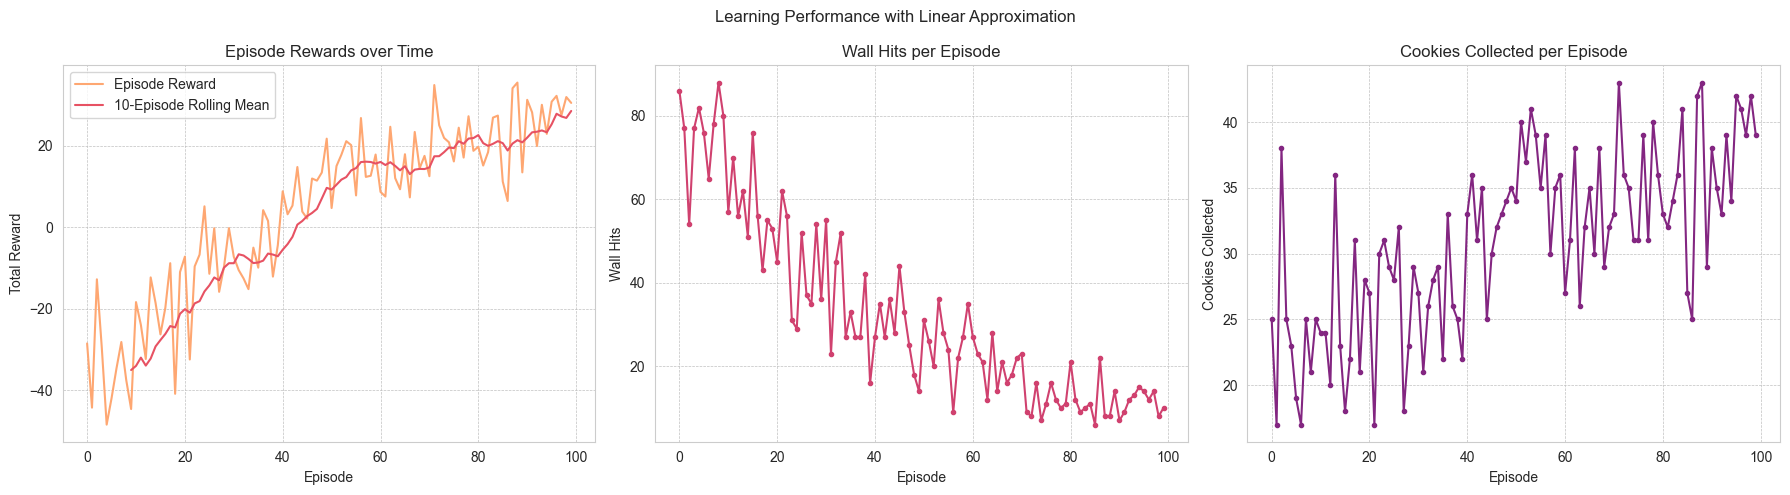

In [15]:
plot_learning_performance(lin_approx_results, method_name="Linear Approximation")

3. Use a neural network to approximate $q_\pi(a, s)$ and solve the control problem using Q-learning.
You may want to consider the use of feature engineering to pre-process the state.

In [16]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.out(x)

In [17]:
def select_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return torch.tensor([[env.action_space.sample()]])
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)

In [18]:
def nn_q_learning(env, policy_net, loss_fn, num_episodes=100, num_steps=1000, discount_factor=1.0,
                  epsilon_start=1.0, epsilon_decay=0.99, epsilon_min=0.1):
    episode_rewards = []
    episode_wall_hits = []
    episode_cookies_collected = []

    epsilon = epsilon_start

    for episode in range(1, num_episodes + 1):
        total_reward = 0
        wall_hits = 0
        cookies_collected = 0

        obs, info = env.reset()
        state = get_features(obs, info)
        state = scaler.transform([state])[0]
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)

        for step in range(1, num_steps + 1):
            action = select_action(state, epsilon, policy_net)
            next_obs, reward, _, _, next_info = env.step(action.item())
            next_state = get_features(next_obs, next_info)

            total_reward += reward

            if wall_hit(state.squeeze(0).numpy(), action.item(), next_state):
                wall_hits += 1

            if reward == 1:
                cookies_collected += 1

            next_state = scaler.transform([next_state])[0]
            next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)

            state_action_values = policy_net(state).gather(1, action).squeeze()

            next_state_values = policy_net(next_state)
            # next_state_values = target_net(next_state)

            max_next_state_values = next_state_values.max()
            expected_state_action_values = reward + (discount_factor * max_next_state_values)

            loss = loss_fn(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.sum().backward()
            optimizer.step()

            state = next_state

        print(f"\rEpisode: {episode}/{num_episodes}   Reward: {total_reward:.3f}   Epsilon: {epsilon:.3f}", end="")

        # if episode % 10 == 0:
        #     target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_min, epsilon_decay * epsilon)

        episode_rewards.append(total_reward)
        episode_wall_hits.append(wall_hits)
        episode_cookies_collected.append(cookies_collected)

    return {
        "episode_rewards": episode_rewards,
        "episode_wall_hits": episode_wall_hits,
        "episode_cookies_collected": episode_cookies_collected,
    }

In [19]:
n_observations = len(get_features(*env.reset()))
n_actions = env.action_space.n

In [20]:
policy_net = DQN(n_observations, n_actions)
# target_net = DQN(n_observations, n_actions)
# target_net.load_state_dict(policy_net.state_dict())

loss_fn = nn.SmoothL1Loss()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4, amsgrad=True)

In [21]:
nn_approx_results = nn_q_learning(env, policy_net, loss_fn)

Episode: 100/100   Reward: 47.007   Epsilon: 0.370

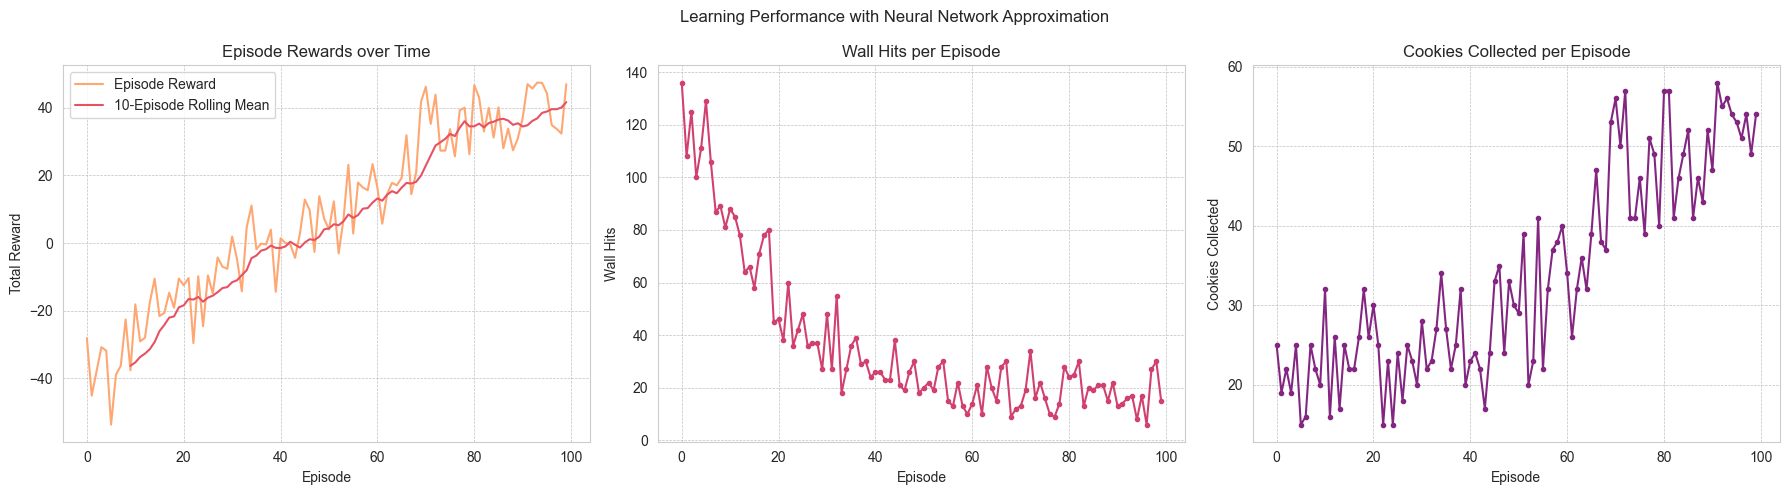

In [22]:
plot_learning_performance(nn_approx_results, method_name="Neural Network Approximation")

5. Implement an actor-critic model to learn directly an optimal policy $\pi(a|s)$.

In [23]:
class ActorCritic(nn.Module):
    def __init__(self, n_features, n_actions, critic_lr=0.005, actor_lr=0.001):
        super().__init__()

        # actor and critic networks
        self.critic = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # estimate v(s)
        )

        self.actor = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)  # estimate action logits
        )

        # optimizers for actor and critic
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x):
        x = torch.Tensor(x)
        state_values = self.critic(x)
        action_logits_vec = self.actor(x)
        return state_values, action_logits_vec

    def select_action(self, state):
        state_values, action_logits = self.forward(state)
        action_pd = torch.distributions.Categorical(logits=action_logits)  # softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return actions, action_log_probs, state_values, entropy

    def get_losses(self, rewards, action_log_probs, value_preds, entropy, gamma, lam, ent_coef):
        T = len(rewards)
        advantages = torch.zeros(T)

        gae = 0
        for t in reversed(range(T - 1)):
            td_error = (rewards[t] + gamma * value_preds[t + 1] - value_preds[t])
            gae = td_error + gamma * lam * gae
            advantages[t] = gae
        
        critic_loss = advantages.pow(2).mean()
        # giving a bonus for higher entropy to encourage exploration
        actor_loss = (-(advantages.detach() * action_log_probs).mean() - ent_coef * entropy)

        return critic_loss, actor_loss

    def update_parameters(self, critic_loss, actor_loss):
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [24]:
def train_actor_critic_agent(env, agent, num_episodes=100, num_steps=1000, gamma=1.0, lam=0.95, ent_coef=0.1):
    critic_losses, actor_losses = [], []
    entropies = []
    episode_rewards = []
    episode_wall_hits, episode_cookies_collected = [], []

    for episode in range(1, num_episodes + 1):
        total_reward = 0
        wall_hits = 0
        cookies_collected = 0

        ep_rewards = torch.zeros(num_steps)
        ep_action_log_probs = torch.zeros(num_steps)
        ep_value_preds = torch.zeros(num_steps)

        obs, info = env.reset()
        state = get_features(obs, info)

        for step in range(1, num_steps + 1):
            action, action_log_probs, state_value_preds, entropy = agent.select_action(state)

            next_obs, reward, _, _, next_info = env.step(action.item())
            next_state = get_features(next_obs, next_info)

            total_reward += reward

            if wall_hit(state, action.item(), next_state):
                wall_hits += 1

            if reward == 1:
                cookies_collected += 1

            ep_rewards[step - 1] = torch.tensor(reward)
            ep_action_log_probs[step - 1] = action_log_probs
            ep_value_preds[step - 1] = torch.squeeze(state_value_preds)

            state = next_state

        print(f"\rEpisode: {episode}/{num_episodes}   Reward: {total_reward:.3f}", end="")

        episode_rewards.append(total_reward)
        episode_wall_hits.append(wall_hits)
        episode_cookies_collected.append(cookies_collected)

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(ep_rewards, ep_action_log_probs, ep_value_preds, entropy, gamma, lam,
                                                   ent_coef)

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)

        critic_losses.append(critic_loss.item())
        actor_losses.append(actor_loss.item())
        entropies.append(entropy.item())

    return {
        "critic_losses": critic_losses,
        "actor_losses": actor_losses,
        "entropies": entropies,
        "episode_rewards": episode_rewards,
        "episode_wall_hits": episode_wall_hits,
        "episode_cookies_collected": episode_cookies_collected,
    }

In [25]:
agent = ActorCritic(n_observations, n_actions)

In [26]:
actor_critic_results = train_actor_critic_agent(env, agent)

Episode: 100/100   Reward: 52.922

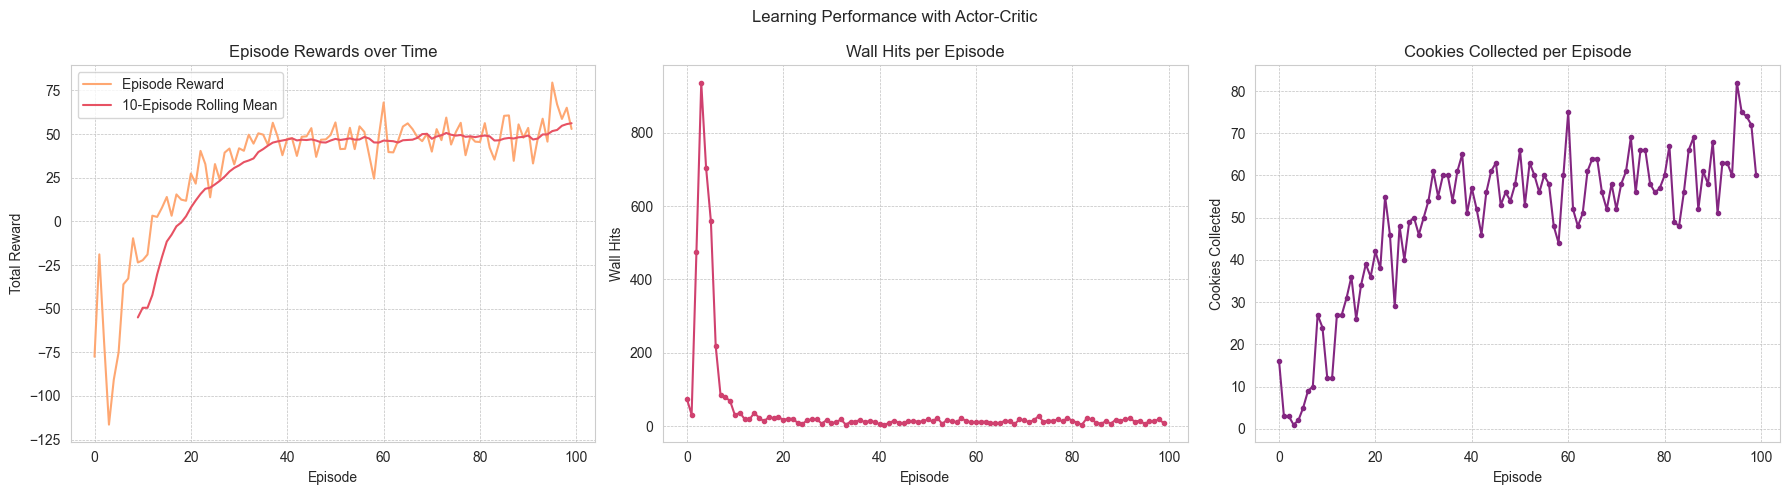

In [27]:
plot_learning_performance(actor_critic_results, method_name="Actor-Critic")

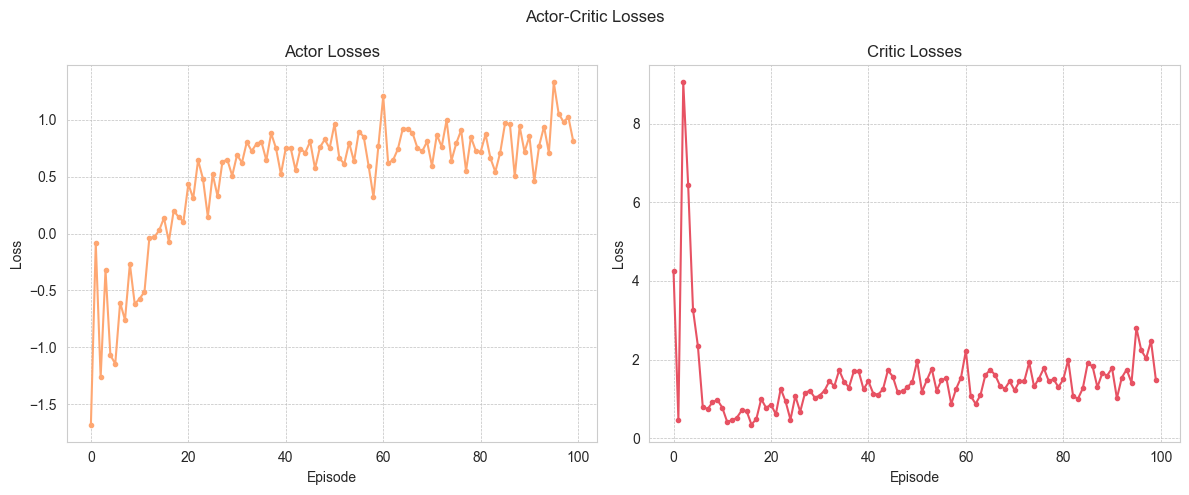

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(actor_critic_results["actor_losses"], color=cmap[12], marker='.')
ax1.set_title('Actor Losses')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Loss')
ax1.grid(color="silver", linestyle='--', linewidth=0.5)

ax2.plot(actor_critic_results["critic_losses"], color=cmap[9], marker='.')
ax2.set_title('Critic Losses')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Loss')
ax2.grid(color="silver", linestyle='--', linewidth=0.5)

fig.suptitle('Actor-Critic Losses')

plt.tight_layout()
plt.show()

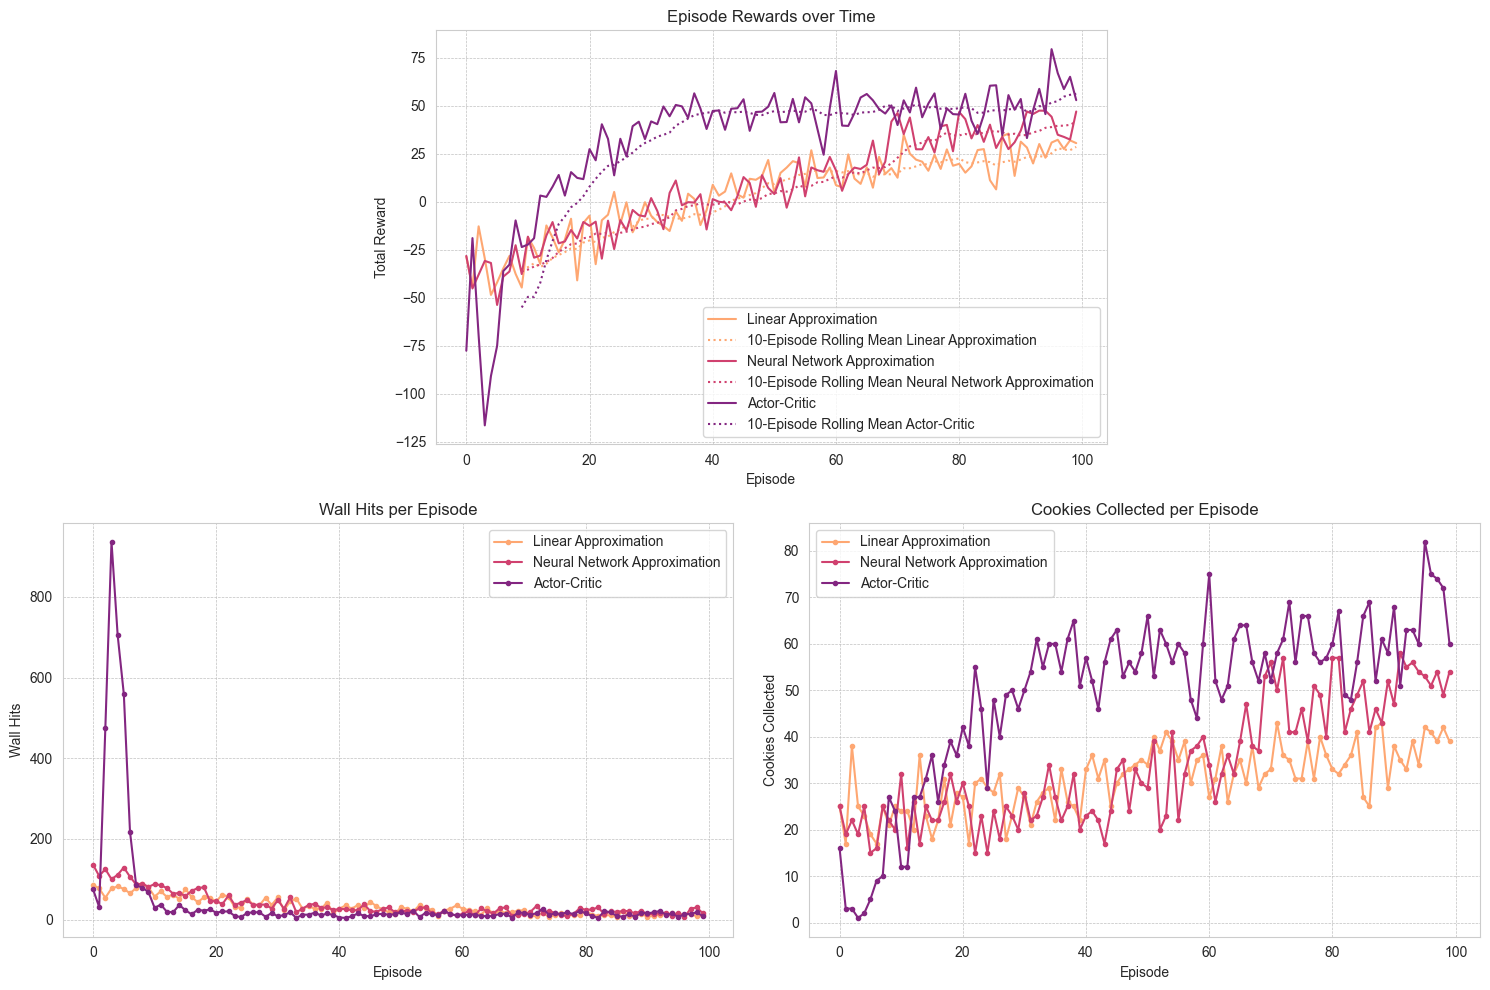

In [29]:
results_list = [lin_approx_results, nn_approx_results, actor_critic_results]
method_names = ["Linear Approximation", "Neural Network Approximation", "Actor-Critic"]
colors = [cmap[12], cmap[8], cmap[5]]

gs = gridspec.GridSpec(2, 4)
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(gs[0, 1:3])
for (results, method_name, c) in zip(results_list, method_names, colors):
    ax1.plot(results["episode_rewards"], color=c, label=method_name)
    ax1.plot(pd.Series(results["episode_rewards"]).rolling(10).mean(), color=c, linestyle=":",
             label=f"10-Episode Rolling Mean {method_name}")
ax1.set_title("Episode Rewards over Time")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward")
ax1.grid(color="silver", linestyle='--', linewidth=0.5)
ax1.legend()

ax2 = fig.add_subplot(gs[1, :2])
for (results, method_name, c) in zip(results_list, method_names, colors):
    ax2.plot(results["episode_wall_hits"], color=c, label=method_name, marker='.')
ax2.set_title('Wall Hits per Episode')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Wall Hits')
ax2.grid(color="silver", linestyle='--', linewidth=0.5)
ax2.legend()

ax3 = fig.add_subplot(gs[1, 2:])
for (results, method_name, c) in zip(results_list, method_names, colors):
    ax3.plot(results["episode_cookies_collected"], color=c, label=method_name, marker='.')
ax3.set_title('Cookies Collected per Episode')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Cookies Collected')
ax3.grid(color="silver", linestyle='--', linewidth=0.5)
ax3.legend()

plt.tight_layout()
plt.show()